In [1]:
import urllib, json
import geopandas as gpd

# Distance from dogparks

data ref: Ravenna, November 2021  
data source: [Ravenna opendata](https://opendata.comune.ra.it/organization/comune-ravenna)  

**Indicator**: the aim of this indicator is to evaluate the coverage of dogparks. To do so it calculates how many residents of each district are close (500m) to a dogpark.  
**Limitations**: population geolocalized data is not available publicly (GDPR), thus this example provides only the covered areas as percentage of total district area. A copy of the data is available in the "data" folder.

### Prepare areas

                                            geometry       frazione
0  POLYGON ((284232.269 4930649.527, 284235.500 4...       DEL MARE
1  POLYGON ((275721.083 4917396.486, 275668.926 4...     RONCALCECI
2  POLYGON ((271213.347 4927446.004, 271222.387 4...     PIANGIPANE
3  POLYGON ((269793.357 4935870.245, 270116.631 4...        MEZZANO
4  POLYGON ((278046.280 4925082.213, 278051.049 4...  CENTRO URBANO


<AxesSubplot:>

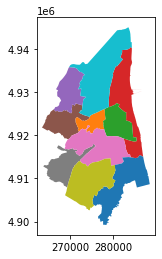

In [2]:
areas_url = 'https://opendata.comune.ra.it/dataset/5ec2b0b3-24f7-4b75-987d-f53658d80064/resource/a8402fb2-3fd5-4a53-a691-263bb8e82640/download/sitra01aa01areeterritoriali.geojson'
areas_response = urllib.request.urlopen(areas_url)
areas_data = json.loads(areas_response.read())
#print(areas_data)
areas = gpd.GeoDataFrame.from_features(areas_data)
areas = areas[['geometry', 'NOME_AT']]
areas = areas.rename( columns = { 'NOME_AT' : 'frazione' } )
areas = areas.set_crs('epsg:4326')
areas = areas.to_crs( epsg = 32633 ) #utm
print(areas.head())
areas.plot( column = 'frazione' )

### Prepare points and buffers

                                           nome  \
87                       AREA CANI VIA LEOPARDI   
130                 AREA CANI ROCCA BRANCALEONE   
247  AREA CANI BORGO MONTONE VIA F. ABBANDONATO   

                                              geometry  
87   MULTIPOLYGON (((275026.408 4921746.057, 275070...  
130  MULTIPOLYGON (((277684.673 4922541.934, 277683...  
247  MULTIPOLYGON (((275218.626 4920614.743, 275227...  


<AxesSubplot:>

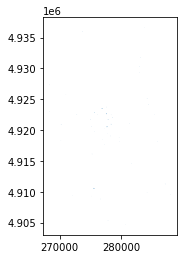

In [3]:
points_url = 'https://opendata.comune.ra.it/dataset/01a9ed32-3b1c-4d0c-b20f-ef0fb5d22c4e/resource/6d4f0753-27af-4d70-aed9-f253c8da4c4f/download/aree_verdi.geojson'
points_response = urllib.request.urlopen(points_url)
points_data = json.loads(points_response.read())
# print(points_data)
points = gpd.GeoDataFrame.from_features(points_data)
points = points[['NOME', 'SOTTOTIPO', 'geometry']]
points = points[ points['SOTTOTIPO'] == 'AREA SGAMBAMENTO CANI' ]
points = points.drop( columns = ['SOTTOTIPO'] )
points = points.rename( columns = { 'NOME' : 'nome' } )
points = points.set_crs('epsg:3004')
points = points.to_crs( epsg = 32633 ) #utm
print(points.head(3))
points.plot()

<AxesSubplot:>

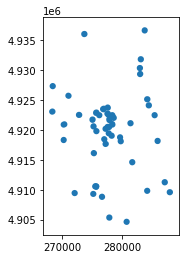

In [4]:
points_buff = points
points_buff['geometry'] = points_buff.geometry.buffer(500)
points_buff.plot()

### Intersection

   frazione                         nome  \
0  DEL MARE    AREA CANI VIA DELLA PRORA   
1  DEL MARE     AREA CANI VIALE LEONARDO   
2  DEL MARE  AREA CANI  DI LIDO DI DANTE   
3  DEL MARE      AREA CANI PORTO CORSINI   
4  DEL MARE       AREA CANI MARINA ROMEA   

                                            geometry  
0  POLYGON ((284401.272 4923588.559, 284352.463 4...  
1  POLYGON ((285352.493 4922973.745, 285354.370 4...  
2  POLYGON ((286030.840 4918668.298, 286077.999 4...  
3  POLYGON ((283460.404 4930181.253, 283444.645 4...  
4  POLYGON ((282971.352 4931309.659, 282923.830 4...  


<AxesSubplot:>

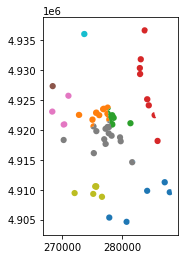

In [5]:
areas_buff = areas.overlay( points_buff, how = 'intersection' )
print(areas_buff.head())
areas_buff.plot( column = 'frazione' )

### Coverage
The covered_percent column holds the indicator values for each district

In [6]:
coverage = areas_buff.dissolve( by = 'frazione', aggfunc = 'sum' )
coverage = coverage.rename( columns = { 'geometry' : 'buffer' } )
coverage = coverage.merge( areas, on = 'frazione' )
coverage['buffer_kmq'] = coverage['buffer'].area / 10**6
coverage['geometry_kmq'] = coverage['geometry'].area / 10**6
coverage['covered_percent'] = 100 * coverage['buffer_kmq'] / coverage['geometry_kmq']
print(coverage.head())

        frazione                                             buffer  \
0    CASTIGLIONE  MULTIPOLYGON (((281232.412 4904673.131, 281215...   
1  CENTRO URBANO  MULTIPOLYGON (((275395.160 4921024.170, 275384...   
2        DARSENA  MULTIPOLYGON (((278244.218 4920354.113, 278241...   
3       DEL MARE  MULTIPOLYGON (((286168.103 4918622.602, 286210...   
4        MEZZANO  POLYGON ((267982.494 4927000.632, 267952.859 4...   

                                                nome  \
0  AREA CANI VIA CAPITANATAAREA CANI CASTIGLIONEA...   
1  AREA CANI VIA LEOPARDIAREA CANI ROCCA BRANCALE...   
2  AREA CANI ROCCA BRANCALEONEAREA CANI GIARDINO ...   
3  AREA CANI VIA DELLA PRORAAREA CANI VIALE LEONA...   
4                       AREA CANI VIA MARINO PASCOLI   

                                            geometry  buffer_kmq  \
0  POLYGON ((286726.373 4915066.675, 286750.492 4...    4.168791   
1  POLYGON ((278046.280 4925082.213, 278051.049 4...    6.099408   
2  POLYGON ((281218.174 4926652.

### Maps

<AxesSubplot:>

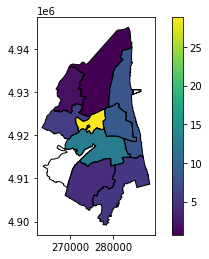

In [7]:
map = coverage[['frazione', 'geometry', 'covered_percent']]
base = map.plot( column = 'covered_percent', legend = True )
areas.plot(ax = base, color = 'none', edgecolor = 'black') # add districts borders to show 0 values better

<AxesSubplot:>

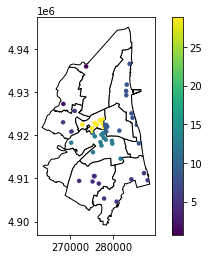

In [8]:
df = coverage[['frazione', 'buffer', 'covered_percent']]
map_buff = gpd.GeoDataFrame( df, geometry = 'buffer' )
base = areas.plot( color = 'white', edgecolor = 'black')
map_buff.plot( ax = base, column = 'covered_percent', legend = True )